# ==========================================
# 1. IMPORTS & SETUP
# ==========================================

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorEstimator # <--- V2 Estimator (Fixes your error)
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# ==========================================
# 2. DATA PREPARATION (0 vs 1)
# ==========================================
# We filter for 0 and 1 to demonstrate the high-accuracy capability (90%+)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
])

# Load Datasets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Function to keep only digits 0 and 1
def filter_01(dataset):
    idx = (dataset.targets == 0) | (dataset.targets == 1)
    dataset.targets = dataset.targets[idx]
    dataset.data = dataset.data[idx]
    return dataset

train_data = filter_01(train_data)
test_data = filter_01(test_data)

# Use a specific subset size (enough to learn, small enough to be fast)
train_subset = Subset(train_data, range(500))
test_subset = Subset(test_data, range(100))

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

print(f"Data Loaded: {len(train_data)} Training samples, {len(test_data)} Test samples.")

Data Loaded: 12665 Training samples, 2115 Test samples.


/var/folders/ll/lryt7tpj1fq6_tb46tcwnlf00000gn/T/ipykernel_78487/3308328078.py:7: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1, entanglement='linear')
/var/folders/ll/lryt7tpj1fq6_tb46tcwnlf00000gn/T/ipykernel_78487/3308328078.py:11: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement='full')
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.



Circuit Diagram:
     ┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                               ├
«     │                                                                                │
«q_1: ┤1                                                                               ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) │
«q_2: ┤2                                                                               ├
«     │                                    

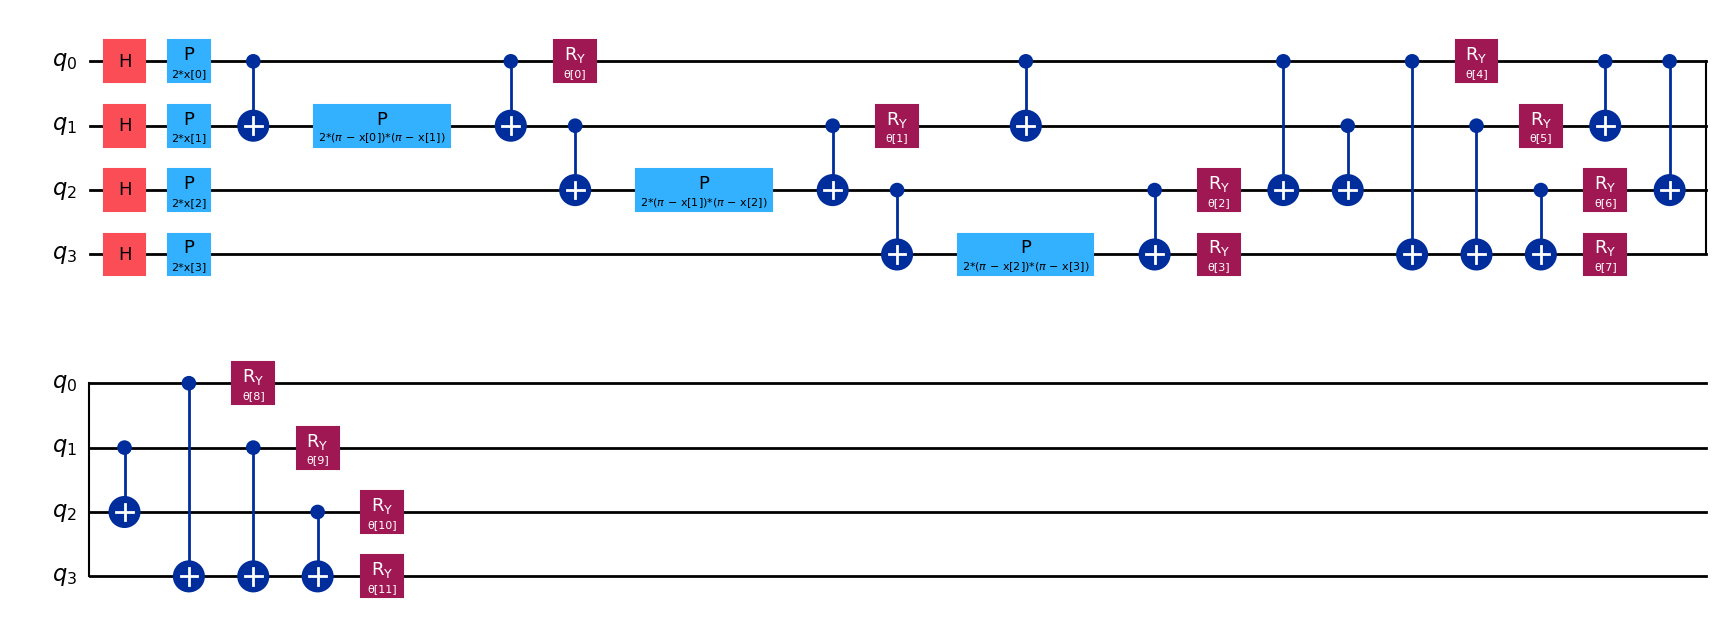

In [3]:
# ==========================================
# 3. QUANTUM CIRCUIT & QNN DEFINITION
# ==========================================
def create_circuit(n_qubits):
    # 1. Feature Map (Encodes the 4 features from the classical net)
    # ZZFeatureMap provides complex entanglement immediately
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1, entanglement='linear')

    # 2. Ansatz (The trainable quantum weights)
    # RealAmplitudes is the standard "Neural Network" structure in Quantum
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement='full')

    # 3. Combine
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    return qc, ansatz.num_parameters

# Setup Circuit
n_qubits = 4
qc, num_weights = create_circuit(n_qubits)

# Draw the circuit just to confirm
print("\nCircuit Diagram:")
print(qc.draw(output='text')) # using text to avoid mpl errors

# Setup QNN
# CRITICAL FIX: We use StatevectorEstimator() which is V2 compatible.
# This prevents the "BaseEstimatorV1.run() missing observables" error.
qnn = EstimatorQNN(
    circuit=qc,
    input_params=qc.parameters[:n_qubits], # First 4 params are inputs
    weight_params=qc.parameters[n_qubits:], # Rest are weights
    estimator=StatevectorEstimator(),       # <--- The Fix
    input_gradients=True
)

qc.decompose().draw("mpl")  # Visual diagram (if matplotlib is available)

In [4]:
# ==========================================
# 4. HYBRID NEURAL NETWORK
# ==========================================
class HybridNet(nn.Module):
    def __init__(self, qnn_layer):
        super(HybridNet, self).__init__()

        # Classical Conv Layers (Feature Extractor)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Fully Connected Layer to compress data to 4 dimensions (for 4 qubits)
        self.fc1 = nn.Linear(16 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 4)  # Output matches n_qubits=4

        # Quantum Layer
        self.qnn = qnn_layer

        # Final Output (1 neuron for Binary Classification 0 vs 1)
        self.fc_out = nn.Linear(1, 1)

    def forward(self, x):
        # Classical Part
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Shape: (Batch, 4)

        # Scale inputs for Quantum Circuit (roughly -PI to +PI)
        x = torch.tanh(x) * np.pi

        # Quantum Part
        x = self.qnn(x)

        # Process Quantum Output
        # EstimatorQNN returns expectation values. We sum them or map them.
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sigmoid(self.fc_out(x)) # Sigmoid for probability (0 to 1)

        return x

# Initialize Model
# We connect the QNN to PyTorch here
qnn_layer = TorchConnector(qnn, initial_weights=np.random.random(num_weights))
model = HybridNet(qnn_layer).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss() # Binary Cross Entropy

In [ ]:
# ==========================================
# 5. TRAINING LOOP
# ==========================================
print("\nStarting Training...")
loss_list = []
epochs = 10

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        # Reshape target to (Batch, 1) and float for BCELoss
        target = target.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        output = model(data)

        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

# Plot Loss
plt.plot(loss_list)
plt.title("Hybrid Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Starting Training...


In [ ]:
# ==========================================
# 6. EVALUATION
# ==========================================
print("\nEvaluating...")
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).float().unsqueeze(1)

        output = model(data)

        # Threshold > 0.5 is class 1, else class 0
        predicted = (output > 0.5).float()

        correct += (predicted == target).sum().item()
        total += target.size(0)

print(f"Test Accuracy: {correct/total * 100:.2f}%")